![running heart rate](run31.png)

Millions of people develop some sort of heart disease every year, and heart disease is the biggest killer of both men and women in the United States and around the world. Statistical analysis has identified many risk factors associated with heart disease, such as age, blood pressure, total cholesterol, diabetes, hypertension, family history of heart disease, obesity, lack of physical exercise, and more.

In this project, you will run statistical tests and models using the Cleveland heart disease dataset to assess one particular factor -- the maximum heart rate one can achieve during exercise and how it is associated with a higher likelihood of getting heart disease.

Examining how heart rate responds to exercise along with other factors such as age, gender, the maximum heart rate achieved may reveal abnormalities that could be indicative of heart disease. Let's find out more!

## The Data
Available on `Cleveland_hd.csv`
| Column     | Type | Description              |
|------------|------|--------------------------|
|`age` | continuous | age in years | 
|`sex` | discrete | 0=female 1=male |
|`cp`| discrete | chest pain type: 1=typical angina, 2=atypical angina, 3=non-anginal pain, 4=asymptom |
|`trestbps`| continuous | resting blood pressure (in mm Hg) |
|`chol`| continuous | serum cholesterol in mg/dl |
|`fbs`| discrete | fasting blood sugar>120 mg/dl: 1=true 0=False |
|`restecg`| discrete | result of electrocardiogram while at rest are represented in 3 distinct values 0=Normal 1=having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 2=showing probable or definite left ventricular hypertrophy Estes' criteria (Nominal) |
|`thalach`| continuous | maximum heart rate achieved |
|`exang`| discrete | exercise induced angina: 1=yes 0=no |
|`oldpeak`| continuous | depression induced by exercise relative to rest |
|`slope`| discrete | the slope of the peak exercise segment: 1=up sloping 2=flat, 3=down sloping
|`ca`| continuous | number of major vessels colored by fluoroscopy that ranged between 0 and 3 |
|`thal`| discrete | 3=normal 6=fixed defect 7=reversible defect |
|`class`| discrete | diagnosis classes: 0=no presence 1=minor indicators for heart disease 2=>1 3=>2 4=major indicators for heart disease|

In [72]:
# Load the necessary packages
install.packages("Metrics")
library(tidyverse)
library(yardstick)
library(Metrics)

# Load the data
hd_data <- read.csv("Cleveland_hd.csv")

# Inspect the first five rows
head(hd_data, 5)

# Start coding here...add as many cells as you like!

The following package(s) will be installed:
- Metrics [0.1.4]
These packages will be installed into "~/renv/library/R-4.2/x86_64-pc-linux-gnu".

# Installing packages --------------------------------------------------------
- Installing Metrics ...                        OK [linked from cache]


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,class
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>
1,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
2,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
3,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
4,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
5,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [73]:
### Additional libraries ###
library(gridExtra) # Grids for plots
library(caret) # ML
library(glue) # String interpolation
if (!requireNamespace("fastDummies", quietly = TRUE)) {
  install.packages("fastDummies")
}
library(fastDummies)

In [74]:
### EDA ###

# Balance of sexes
table(hd_data["sex"])

sex
  0   1 
 97 206 

In [75]:
# Adjust figure size
options(repr.plot.width = 4, repr.plot.height = 4)

# Distribution of age
p <- ggplot(hd_data, aes(x = age)) + 
     geom_histogram(binwidth = 5, fill = "dark green", color = "black") + 
     labs(title = "Histogram of Age", x = "Age", y = "Frequency") + 
     theme_minimal()


In [76]:
# Convert class column to binary and as factor
hd_data_2 <- hd_data %>% mutate(class = as.factor(ifelse(class == 0, 0, 1)), sex = as.factor(sex))

# Convert the rest of categorical features as factors
hd_data_2 <- hd_data %>% mutate(class = as.factor(ifelse(class == 0, 0, 1)), sex = as.factor(sex))


In [77]:
str(hd_data_2)

'data.frame':	303 obs. of  14 variables:
 $ age     : int  63 67 67 37 41 56 62 57 63 53 ...
 $ sex     : Factor w/ 2 levels "0","1": 2 2 2 2 1 2 1 1 2 2 ...
 $ cp      : int  1 4 4 3 2 2 4 4 4 4 ...
 $ trestbps: int  145 160 120 130 130 120 140 120 130 140 ...
 $ chol    : int  233 286 229 250 204 236 268 354 254 203 ...
 $ fbs     : int  1 0 0 0 0 0 0 0 0 1 ...
 $ restecg : int  2 2 2 0 2 0 2 0 2 2 ...
 $ thalach : int  150 108 129 187 172 178 160 163 147 155 ...
 $ exang   : int  0 1 1 0 0 0 0 1 0 1 ...
 $ oldpeak : num  2.3 1.5 2.6 3.5 1.4 0.8 3.6 0.6 1.4 3.1 ...
 $ slope   : int  3 2 2 3 1 1 3 1 2 3 ...
 $ ca      : int  0 3 2 0 0 0 2 0 1 0 ...
 $ thal    : int  6 3 7 3 3 3 3 3 7 7 ...
 $ class   : Factor w/ 2 levels "0","1": 1 2 2 1 1 1 2 1 2 2 ...


In [78]:
# Check potential missing values

NA_counts <- colSums(is.na(hd_data_2))

print(NA_counts)

     age      sex       cp trestbps     chol      fbs  restecg  thalach 
       0        0        0        0        0        0        0        0 
   exang  oldpeak    slope       ca     thal    class 
       0        0        0        4        2        0 


ca and thal have missing values.

In [79]:
### Check if distribution of numeric features is normal ###

# Shapiro-Wilk normality test
for (name in names(hd_data_2)) {
	if (is.numeric(hd_data_2[[name]])) {
		result <- shapiro.test(hd_data_2[[name]])
		if (result$p.value < 0.05) {
			print(paste(name, "is NOT normally distributed.", " p.value:", format(result$p.value, digits = 2)))
		} else {
			print(paste(name, "is normally distributed.", " p.value:", format(result$p.value, digits = 2)))
		}
	}
}

[1] "age is NOT normally distributed.  p.value: 0.0061"
[1] "cp is NOT normally distributed.  p.value: 2e-19"
[1] "trestbps is NOT normally distributed.  p.value: 1.8e-06"
[1] "chol is NOT normally distributed.  p.value: 5.9e-09"
[1] "fbs is NOT normally distributed.  p.value: 5.4e-30"
[1] "restecg is NOT normally distributed.  p.value: 1.2e-24"
[1] "thalach is NOT normally distributed.  p.value: 7e-05"
[1] "exang is NOT normally distributed.  p.value: 3.8e-26"
[1] "oldpeak is NOT normally distributed.  p.value: 8.2e-17"
[1] "slope is NOT normally distributed.  p.value: 2.6e-21"
[1] "ca is NOT normally distributed.  p.value: 4e-22"
[1] "thal is NOT normally distributed.  p.value: 3.4e-24"


In [80]:
# Make lists for continuous (numeric) and discrete (categorical) features
numeric_features = c()
categorical_features = c()

# Loop through each column name in the dataframe
for (name in names(hd_data_2)) { 
	
  # Check if the column is numeric and has more than 10 unique values
  if (is.numeric(hd_data_2[[name]]) && length(unique(hd_data_2[[name]])) > 10) {
	  
    # Append the column name to the numeric_features vector
    numeric_features <- c(numeric_features, name)
  } else {
	categorical_features <- c(categorical_features, name)
  }
}

# Delete class from categorical feature as it's the target
categorical_features <- categorical_features[categorical_features != "class"]

print(numeric_features)
print(categorical_features)

# Remove rows containing missing values
hd_data_2 <- na.omit(hd_data_2)


[1] "age"      "trestbps" "chol"     "thalach"  "oldpeak" 
[1] "sex"     "cp"      "fbs"     "restecg" "exang"   "slope"   "ca"     
[8] "thal"   


   feature feature_type     test      p_value
1      age      numeric Wilcoxon 3.672541e-05
2 trestbps      numeric Wilcoxon 2.345960e-02
3     chol      numeric Wilcoxon 4.668918e-02
4  thalach      numeric Wilcoxon 1.675290e-13
5  oldpeak      numeric Wilcoxon 1.538610e-12


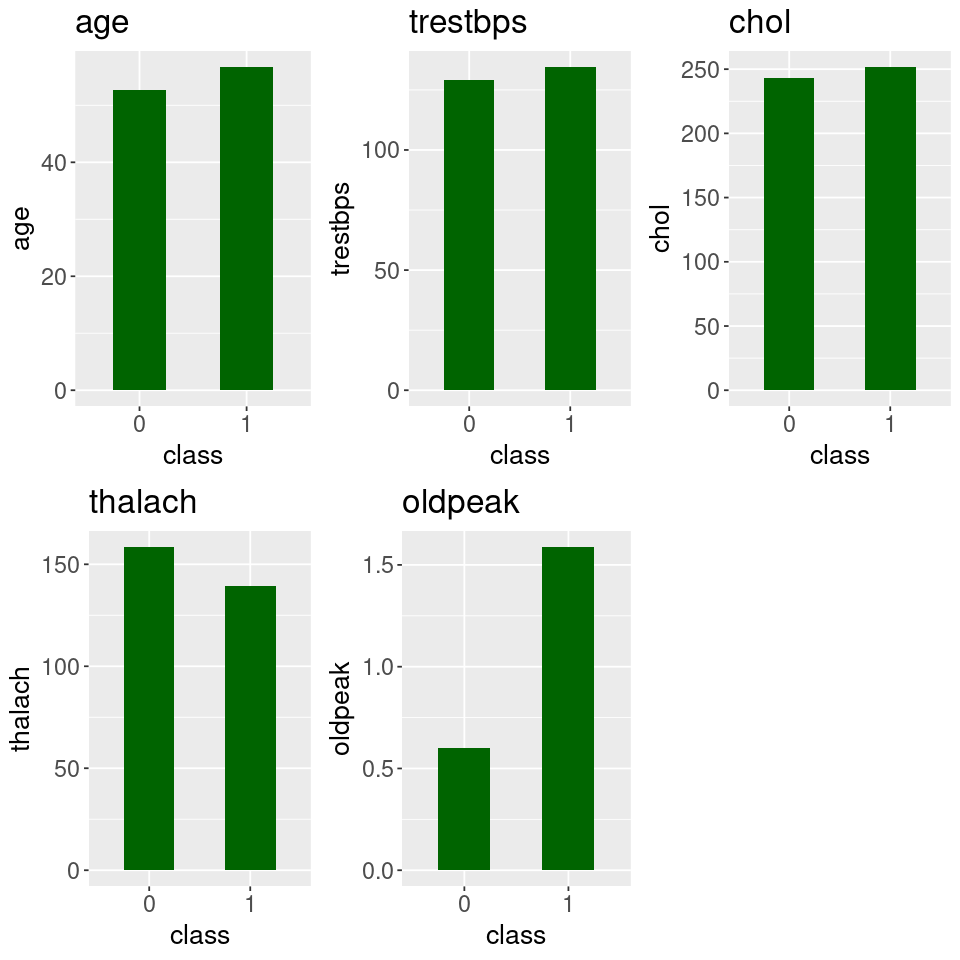

In [88]:
#########################################
# Plot numeric feature vs heart disease #
#########################################

# Adjust figure size
options(repr.plot.width = 8, repr.plot.height = 8)

# Create an empty dataframe to store numeric feature pvalues
numeric_feature_p_values <- data.frame(feature = character(), feature_type = character(), test = character(), p_value = numeric())

# Create a list to hold all the plots
numeric_plots <- list()

# Create a list to hold all the tests
numeric_tests <- list()

for (i in 1:length(numeric_features)) {
  feature <- numeric_features[i]
  
  # Group by healthy vs disease and calculate means
  hd_data_means <- hd_data_2 %>% 
    group_by(class) %>%
    summarise(means = mean(.data[[feature]], na.rm = TRUE))
  
  # Bar plots and Wilcoxon test (none of the values is normally distributed)
  plot <- ggplot(hd_data_means, aes(x = class, y = means)) + 
    geom_bar(stat = "identity", width = 0.5, fill = "darkgreen") +   
    labs(title = paste(feature), x = "class", y = feature) + 
	theme(
    plot.title = element_text(size = 20),      
    axis.title.x = element_text(size = 16),    
    axis.title.y = element_text(size = 16),   
    axis.text.x = element_text(size = 14),            
    axis.text.y = element_text(size = 14)            
  )
  
  # print(hd_data_means)
  
  x1 <- hd_data_2 %>% filter(class == 0) %>% pull(feature)
  x2 <- hd_data_2 %>% filter(class == 1) %>% pull(feature)
  
  test <- wilcox.test(x1, x2, paired = FALSE)
  
  # Store results in the dataframe
  numeric_feature_p_values <- rbind(numeric_feature_p_values, data.frame(feature = feature, feature_type = "numeric", test = "Wilcoxon", p_value = test$p.value))
  
  # Add the plot and test to the lists
  numeric_plots[[i]] <- plot
  numeric_tests[[i]] <- test
  
}

# Create a grid of plots
grid.arrange(grobs = numeric_plots, ncol = 3)

# Print results
print(numeric_feature_p_values)

Warning message in chisq.test(hd_data_2$class, hd_data_2[[feature]]):
“Chi-squared approximation may be incorrect”


  feature feature_type       test      p_value
1     sex  categorical Chi-square 2.945690e-06
2      cp  categorical Chi-square 1.178284e-16
3     fbs  categorical Chi-square 1.000000e+00
4 restecg  categorical Chi-square 8.331151e-03
5   exang  categorical Chi-square 9.510884e-13
6   slope  categorical Chi-square 3.630107e-10
7      ca  categorical Chi-square 1.372578e-15
8    thal  categorical Chi-square 1.241673e-18


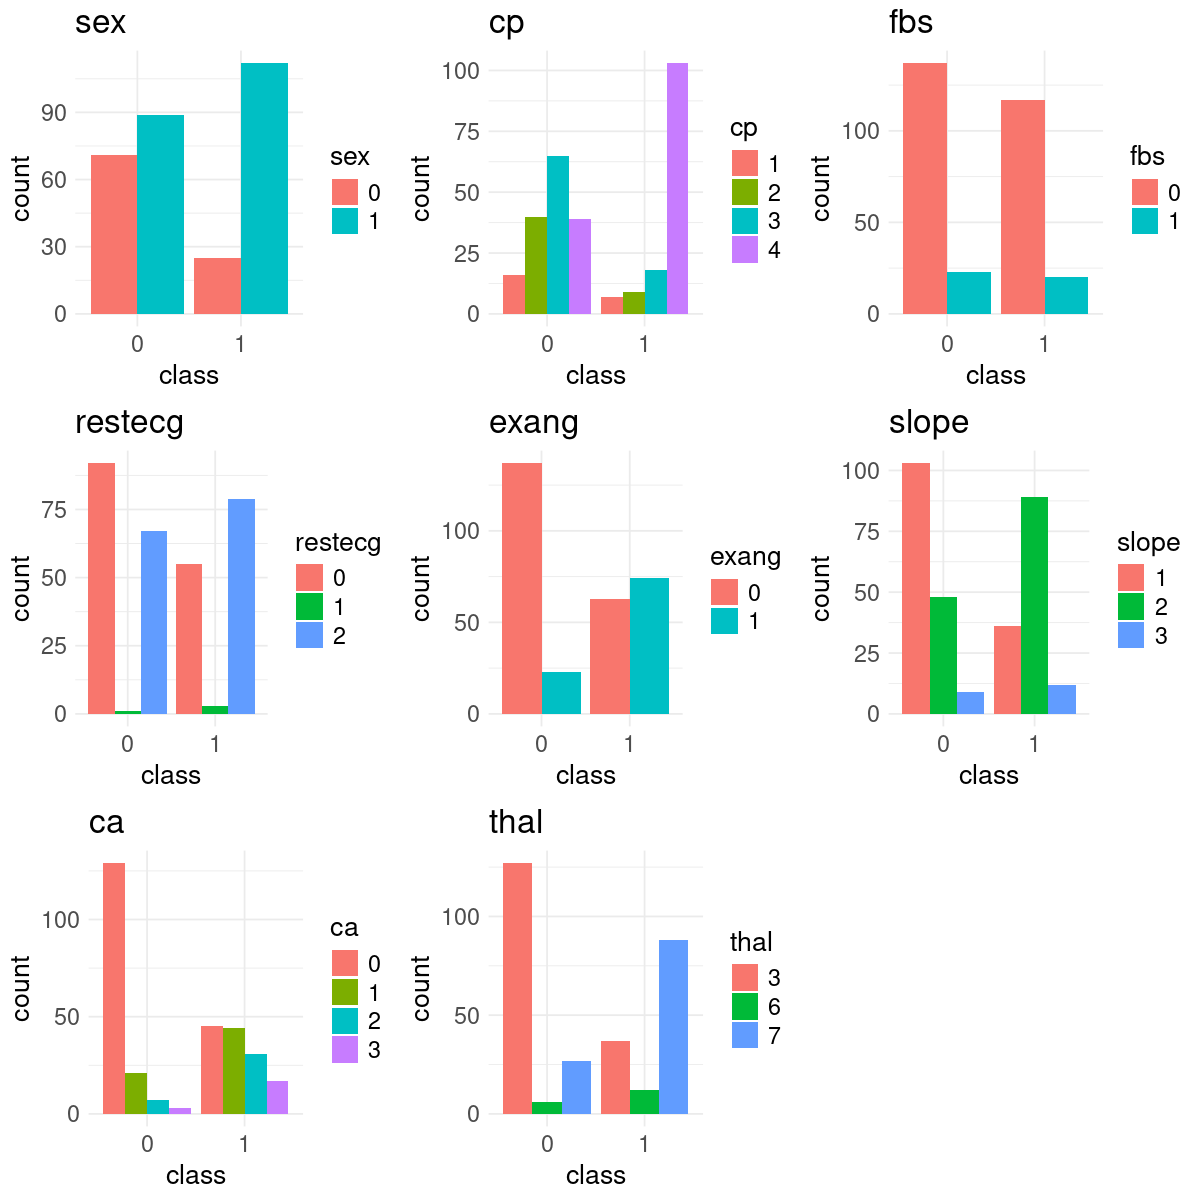

In [82]:
#############################################
# Plot categorical feature vs heart disease #
#############################################

# Adjust figure size
options(repr.plot.width = 10, repr.plot.height = 10)

# Create an empty dataframe to store categorical feature pvalues
categorical_feature_p_values <- data.frame(feature = character(), feature_type = character(), test = character(), p_value = numeric())

# Create a list to hold all the plots and tests
categrorical_plots <- list()
categorical_tests <- list()

# Create a grouped bar plot for each categorical feature
for (i in 1:length(categorical_features)) {
	feature <- categorical_features[i]
 
	# Make a grouped bar plot
    cat_plot <- ggplot(hd_data_2, aes(x = factor(class), fill = factor(.data[[feature]]))) + 
	geom_bar(position = "dodge") + 
	labs(title = paste(feature), x = "class", y = "count") + 
    theme_minimal() +
	scale_fill_discrete(name = feature) + 
	theme(
    plot.title = element_text(size = 20),      
    axis.title.x = element_text(size = 16),    
    axis.title.y = element_text(size = 16),    
    axis.text.x = element_text(size = 14),                    
    axis.text.y = element_text(size = 14),                    
    legend.title = element_text(size = 16),    
    legend.text = element_text(size = 14)                     
  )
	
	# Chi-square test
	chisq_test <- chisq.test(hd_data_2$class, hd_data_2[[feature]])
	
	# Store results in the dataframe
	categorical_feature_p_values <- rbind(categorical_feature_p_values, data.frame(feature = feature, feature_type = "categorical", test = "Chi-square", p_value = chisq_test$p.value))
	
	# Add the plot and test to the lists
  	categrorical_plots[[i]] <- cat_plot
	categorical_tests[[i]] <- chisq_test
	
}

# Create a grid of plots
grid.arrange(grobs = categrorical_plots, ncol = 3)

# Print results
print(categorical_feature_p_values)

In [84]:
### Select the top 3 predictors related to heart disease ###

# Create one dataframe for both numeric and categorical feature
feature_p_values <- rbind(numeric_feature_p_values, categorical_feature_p_values)

# Sort feature_p_values by p-value
feature_p_values <- feature_p_values[order(feature_p_values$p_value),]

# Create an empty list to store the top 3 predictors related to heart disease
highly_significant <- character()

# Add the top 3 feature names to the list
for (i in 1:3) {
  highly_significant[i] <- feature_p_values[i, "feature"]
}

print(paste("Top 3 features related to heart disease: ", toString(highly_significant)))

[1] "Top 3 features related to heart disease:  thal, cp, ca"


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


Accuracy: 83.1460674157303%


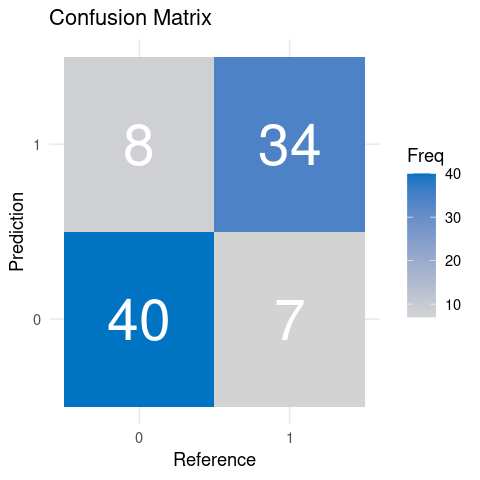

In [85]:
#######################
# Logistic regression #
#######################

# Select top 3 columns from df that are highly_significant
df <- hd_data_2 %>% select(all_of(c(highly_significant, "class")))

# One hot encoding
df <- dummy_cols(df, select_columns = highly_significant, remove_selected_columns = TRUE)

# Define X and y
X <- select(df, -class)
y <- df$class

# Train-Test split
set.seed(42)
train_index <- createDataPartition(y, p = 0.7, list = FALSE)
X_train <- X[train_index, ]
y_train <- y[train_index]
X_test <- X[-train_index, ]
y_test <- y[-train_index]

# Fit logistic regression model
model <- glm(y_train ~., data = X_train, family = binomial)

# Make predictions
predictions <- predict(model, newdata = X_test, type = "response")
predicted_classes <- ifelse(predictions > 0.5, 1, 0)

# Convert predictions and y_test to factors
predicted_classes <- as.factor(predicted_classes)
y_test_factor <- as.factor(y_test)

# Evaluate the model
accuracy <- mean(predicted_classes == y_test_factor)
print(glue("Accuracy: {accuracy * 100}%"))

# Convert highly_significant to a list for final evaluation
highly_significant <- as.list(highly_significant)

# Detailed performance metrics
confusion <- confusionMatrix(predicted_classes, y_test_factor)

# Plot the confusion matrix
options(repr.plot.width = 4, repr.plot.height = 4)

df_conf_mat <- as.data.frame(confusion$table)

ggplot(df_conf_mat, aes(x = Reference, y = Prediction, fill = Freq)) +
  geom_tile() +
  geom_text(aes(label = Freq), color = "white", size = 12) +
  scale_fill_gradient(low = "#D3D3D3", high = "#0073C2") +
  labs(x = "Reference", y = "Prediction", title = "Confusion Matrix") +
  theme_minimal()

